In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import logging
import copy
import torch
import opacus
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')  # noqa
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics

from models.fully_connected import FullyConnected

# opacus doesn't respect my logging handler :(
logger = logging.getLogger("abstract_gradient_training")
logger.handlers.clear()

In [2]:
results_dir = ".results"
notebook_id = "gpt-2-imdb-v0"

In [8]:
# helper function
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        training = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        training = []
        np.random.seed(seed)
        torch.manual_seed(seed)
        def log(x, param_l, param_n, param_u):
            percent_certified = test_metrics.proportion_certified(
                param_n, param_l, param_u, *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
            )
            training.append((x[1], percent_certified,))  # nom acc, percent certified
        config.callback = log

        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, train_loader, test_loader, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, train_loader, test_loader, transform=ct_utils.propagate_conv_layers
            )
        torch.save((training), fname)
    torch.cuda.empty_cache()
    return training

In [9]:
# get dataset
batchsize = 20000
X = np.load('.datasets/GPT2_IMDB_X_test.npy')
y = np.load('.datasets/GPT2_IMDB_Y_test.npy')
X_train = np.load('.datasets/GPT2_IMDB_X_train.npy')[10000-1:]
y_train = np.load('.datasets/GPT2_IMDB_Y_train.npy')[10000-1:]
X = np.concatenate((X, X_train), axis=0)
y = np.concatenate((y, y_train), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

In [10]:

def get_epsilon_delta(
    config: agt.AGTConfig,
    dl_train: torch.utils.data.DataLoader,
    delta: float = 10e-5,
) -> float:
    """
    For the given model and abstract gradient training config, compute the equivalent epsilon and delta values using
    opacus.

    Args:
        model (torch.nn.Sequential): Neural network model. Must be a torch.nn.Sequential object with dense layers and
            ReLU activations only. The model may have other layers (e.g. convolutional layers) before the dense section,
            but these must be fixed and are not trained. If fixed non-dense layers are provided, then the transform
            function must be set to propagate bounds through these layers.
        config (AGTConfig): Configuration object for the abstract gradient training module. See the configuration module
            for more details.
        dl_train (DataLoader): Training data loader.
        delta (float, optional): Desired delta value for the privacy calculation. Defaults to 10e-5.

    Returns:
        float: The epsilon value for the given model and config.
    """

    # get the config variables
    device = config.device
    lr_decay = config.lr_decay
    lr_min = config.lr_min
    dp_sgd_sigma = config.dp_sgd_sigma
    clipping = config.clip_gamma
    learning_rate = config.learning_rate
    n_epochs = config.n_epochs
    batchsize = next(iter(dl_train))[0].size(0)
    model = FullyConnected(in_dim=768, out_dim=1, hidden_lay=1, hidden_dim=100).to(device)

    if config.loss == "binary_cross_entropy":
        criterion = torch.nn.BCEWithLogitsLoss()
    else:
        raise NotImplementedError(f"Loss function {config.loss} not implemented for eps-delta calculation.")

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    privacy_engine = opacus.PrivacyEngine(accountant="rdp")
    model_private, optimizer_private, data_loader_private = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=dl_train,
        noise_multiplier=dp_sgd_sigma,
        max_grad_norm=clipping,
        poisson_sampling=False,
    )

    def get_lr(epoch):
        lr = max(1 / (1 + lr_decay * epoch), lr_min / learning_rate)
        return lr

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_private, get_lr)

    for _ in range(n_epochs):
        for i, (x, u) in enumerate(dl_train):
            # AGT only takes full batches
            if u.size(0) < batchsize:
                break
            u, x = u.to(device), x.to(device)
            output = model_private(x)
            loss = criterion(output.squeeze(), u.squeeze().float())
            # Backward and optimize
            optimizer_private.zero_grad()
            loss.backward()
            optimizer_private.step()
            scheduler.step()
        print(f"Epoch {_}, epsilon: {privacy_engine.accountant.get_epsilon(delta=delta)}")

    # compute privacy guarantees
    epsilon = privacy_engine.accountant.get_epsilon(delta=delta)
    return epsilon


In [6]:
seed = 2
nominal_config = AGTConfig(
    fragsize = 5000,
    learning_rate = 0.08,
    n_epochs = 51,
    device = "cuda:0",
    forward_bound = "interval",
    backward_bound = "interval",
    clip_gamma = 0.1,
    early_stopping=False,
    loss = "binary_cross_entropy",
    lr_decay = 2.0,
    lr_min=0.001,    
)
torch.manual_seed(seed)
np.random.seed(seed)
model = FullyConnected(in_dim=768, out_dim=1, hidden_lay=1, hidden_dim=100)
prior_acc = agt.test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
)[1]

print("Prior accuracy: ", prior_acc)
print("*****")


09/26/2024 14:36:26:WARNING:k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


Prior accuracy:  0.4853786528110504
*****


In [14]:

training = []
np.random.seed(seed)
torch.manual_seed(seed)
def log(x, param_l, param_n, param_u):
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
    )
    training.append((x[1], percent_certified,))  # nom acc, percent certified

conf = copy.deepcopy(nominal_config)
conf.callback = log
conf.k_private = 10
conf.learning_rate = 0.1
conf.dp_sgd_sigma = 1.0

# print("Epsilon: ", get_epsilon_delta(conf, train_loader, delta=10e-5))  # sigma=1.0, eps=25.5

param_l, param_n, param_u = agt.privacy_certified_training(
    model, conf, train_loader, test_loader, transform=ct_utils.propagate_conv_layers
)

09/26/2024 14:42:39:INFO:=================== Starting Privacy Certified Training ===================
09/26/2024 14:42:39:INFO:Starting epoch 1
09/26/2024 14:42:40:INFO:Training batch 1: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.0 
09/26/2024 14:42:40:INFO:Starting epoch 2
09/26/2024 14:42:41:INFO:Training batch 2: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.00411 
09/26/2024 14:42:41:INFO:Starting epoch 3
09/26/2024 14:42:42:INFO:Training batch 3: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.00642 
09/26/2024 14:42:42:INFO:Starting epoch 4
09/26/2024 14:42:43:INFO:Training batch 4: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.00841 
09/26/2024 14:42:44:INFO:Starting epoch 5
09/26/2024 14:42:44:INFO:Training batch 5: Network eval bounds=(0.49, 0.49, 0.5 ), W0 Bound=0.0102 
09/26/2024 14:42:45:INFO:Starting epoch 6
09/26/2024 14:42:45:INFO:Training batch 6: Network eval bounds=(0.5 , 0.51, 0.52), W0 Bound=0.0119 
09/26/2024 14:42:46:INFO:Starting epoch 7
09/26

In [15]:
model_copy = copy.deepcopy(model)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=nominal_config.learning_rate)


for _ in range(nominal_config.n_epochs):
    for i, (x, u) in enumerate(train_loader):
        # AGT only takes full batches
        if u.size(0) < batchsize:
            break
        u, x = u.to(nominal_config.device), x.to(nominal_config.device)
        output = model_copy(x)
        loss = criterion(output.squeeze(), u.squeeze().float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [8]:
k_unlearns = [5, 25, 50, 100]
unlearning_results = {}

for k in k_unlearns:
    conf = copy.deepcopy(nominal_config)
    conf.k_unlearn = k
    unlearning_results[k] = run_with_config(conf)

In [9]:
k_private = [5, 10, 25, 50]
privacy_results = {}

for k in k_private:
    conf = copy.deepcopy(nominal_config)
    conf.dp_sgd_sigma = 1.0
    conf.learning_rate = 0.1
    conf.k_private = k
    privacy_results[k] = run_with_config(conf)

In [10]:
# set plotting options
sns.set_theme(context="poster", style="whitegrid", font_scale=2.15)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
unlearning_palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D"]
cm_unlearning = mpl.colors.ListedColormap(unlearning_palette)
privacy_palette = ["#B5FFE1", "#93E5AB", "#65B891", "#4E878C"]
cm_privacy = mpl.colors.ListedColormap(privacy_palette)
fontsize = "large"

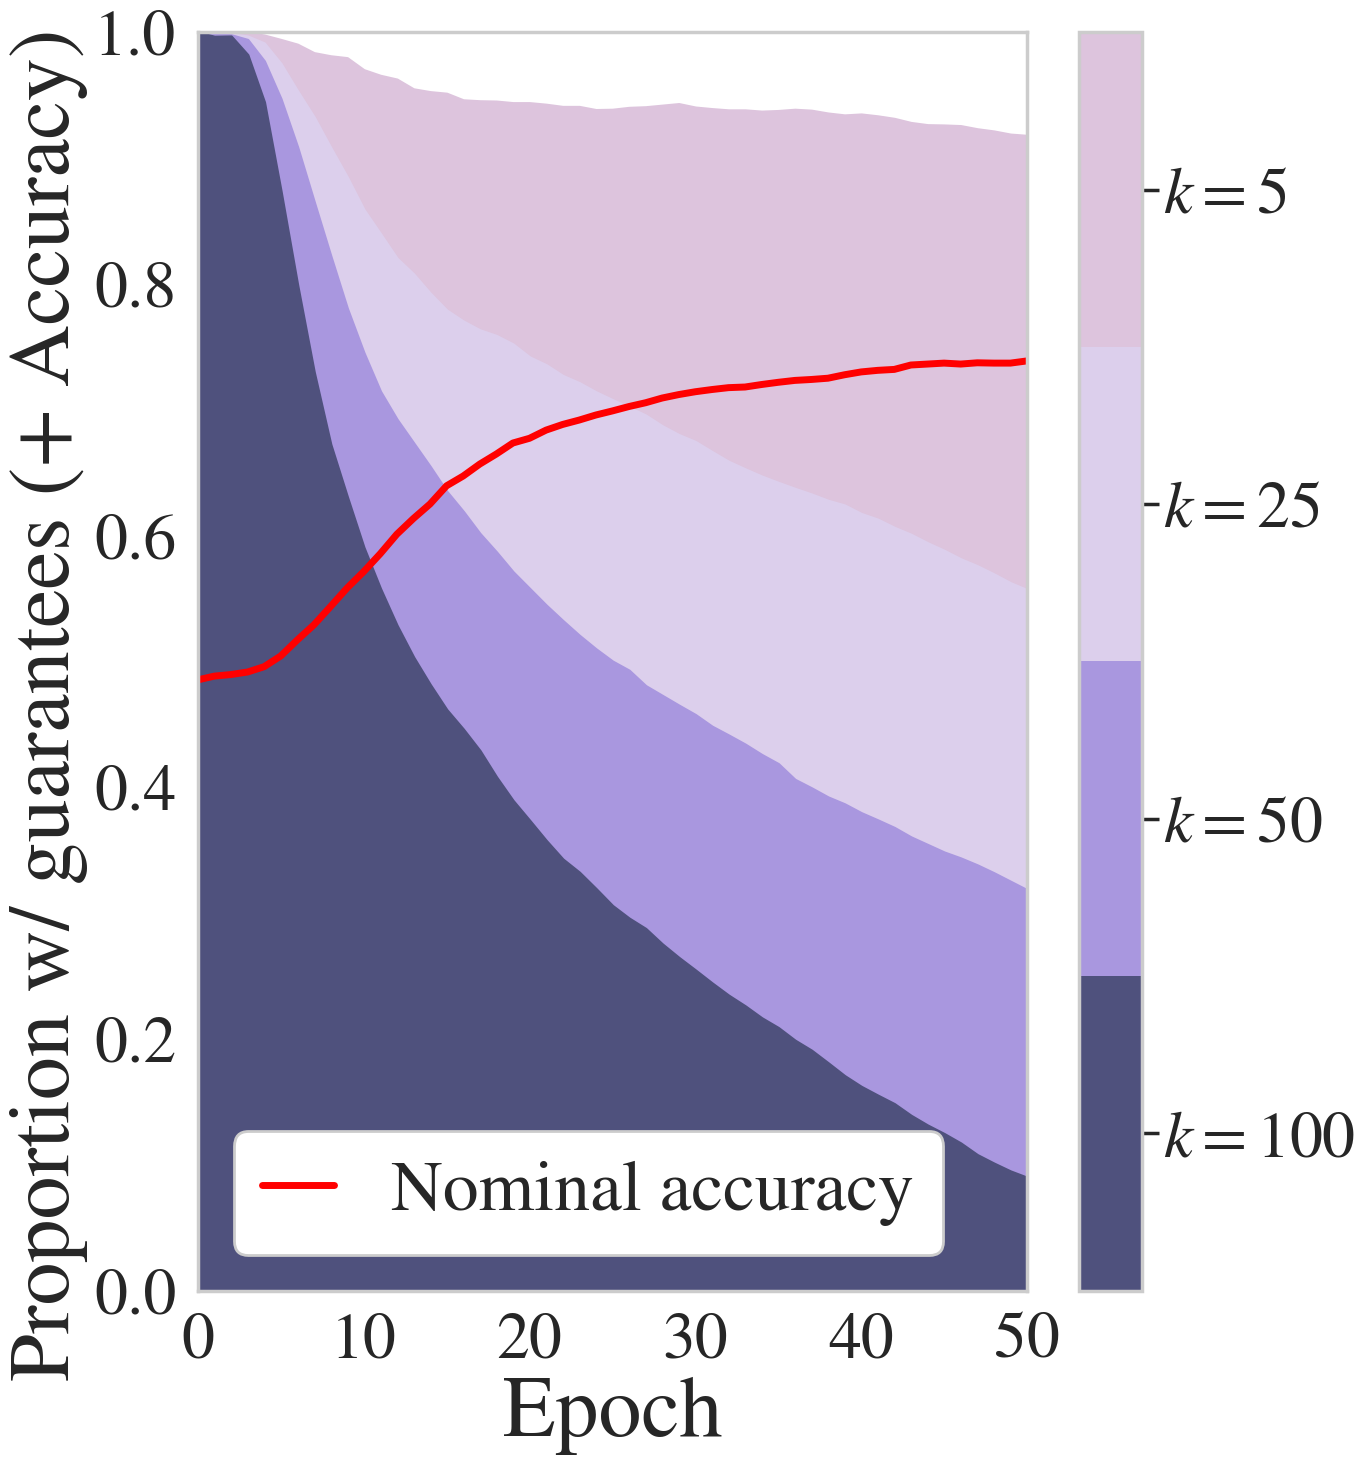

In [11]:
nom_acc_unlearn = [x[0] for x in unlearning_results[100]]
nom_acc_privacy = [x[0] for x in privacy_results[5]]
epochs = list(range(len(nom_acc_unlearn)))

fig, ax = plt.subplots(1, 1, figsize=(15, 16), layout="tight")
# plot unlearning results
colors = iter(unlearning_palette)
ax.fill_between(epochs, [1] * len(nom_acc_unlearn), color="#ffffff")
for k, v in unlearning_results.items():
    ax.fill_between(epochs, [x[1] for x in v], color=next(colors))

# ax.set_title("Rate of\nUnlearning-Safe Predictions", fontsize=fontsize, pad=50)
ax.set_xlim(0, len(nom_acc_unlearn) - 1)
ax.set_ylim(0, 1)
ax.plot(epochs, nom_acc_unlearn, color="red", label="Nominal accuracy", lw=5)
ax.set_xlabel("Epoch", fontsize=fontsize)
ax.set_ylabel("Proportion w/ guarantees (+ Accuracy)    ", fontsize=fontsize)
ax.legend(loc="lower left", fontsize="medium", framealpha=1.0, handlelength=1.0)
ax.set_xticks(range(0, len(nom_acc_unlearn) + 1, 10))

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.colors.ListedColormap(unlearning_palette[::-1])),
    ax=ax,
    orientation="vertical",
)
cbar.set_ticks([0.125, 0.375, 0.625, 0.875])
cbar.set_ticklabels([f"$k={k}$" for k in k_unlearns][::-1])

plt.savefig(".figures/gpt2_finetuning_unlearning.pdf", bbox_inches="tight", dpi=300)

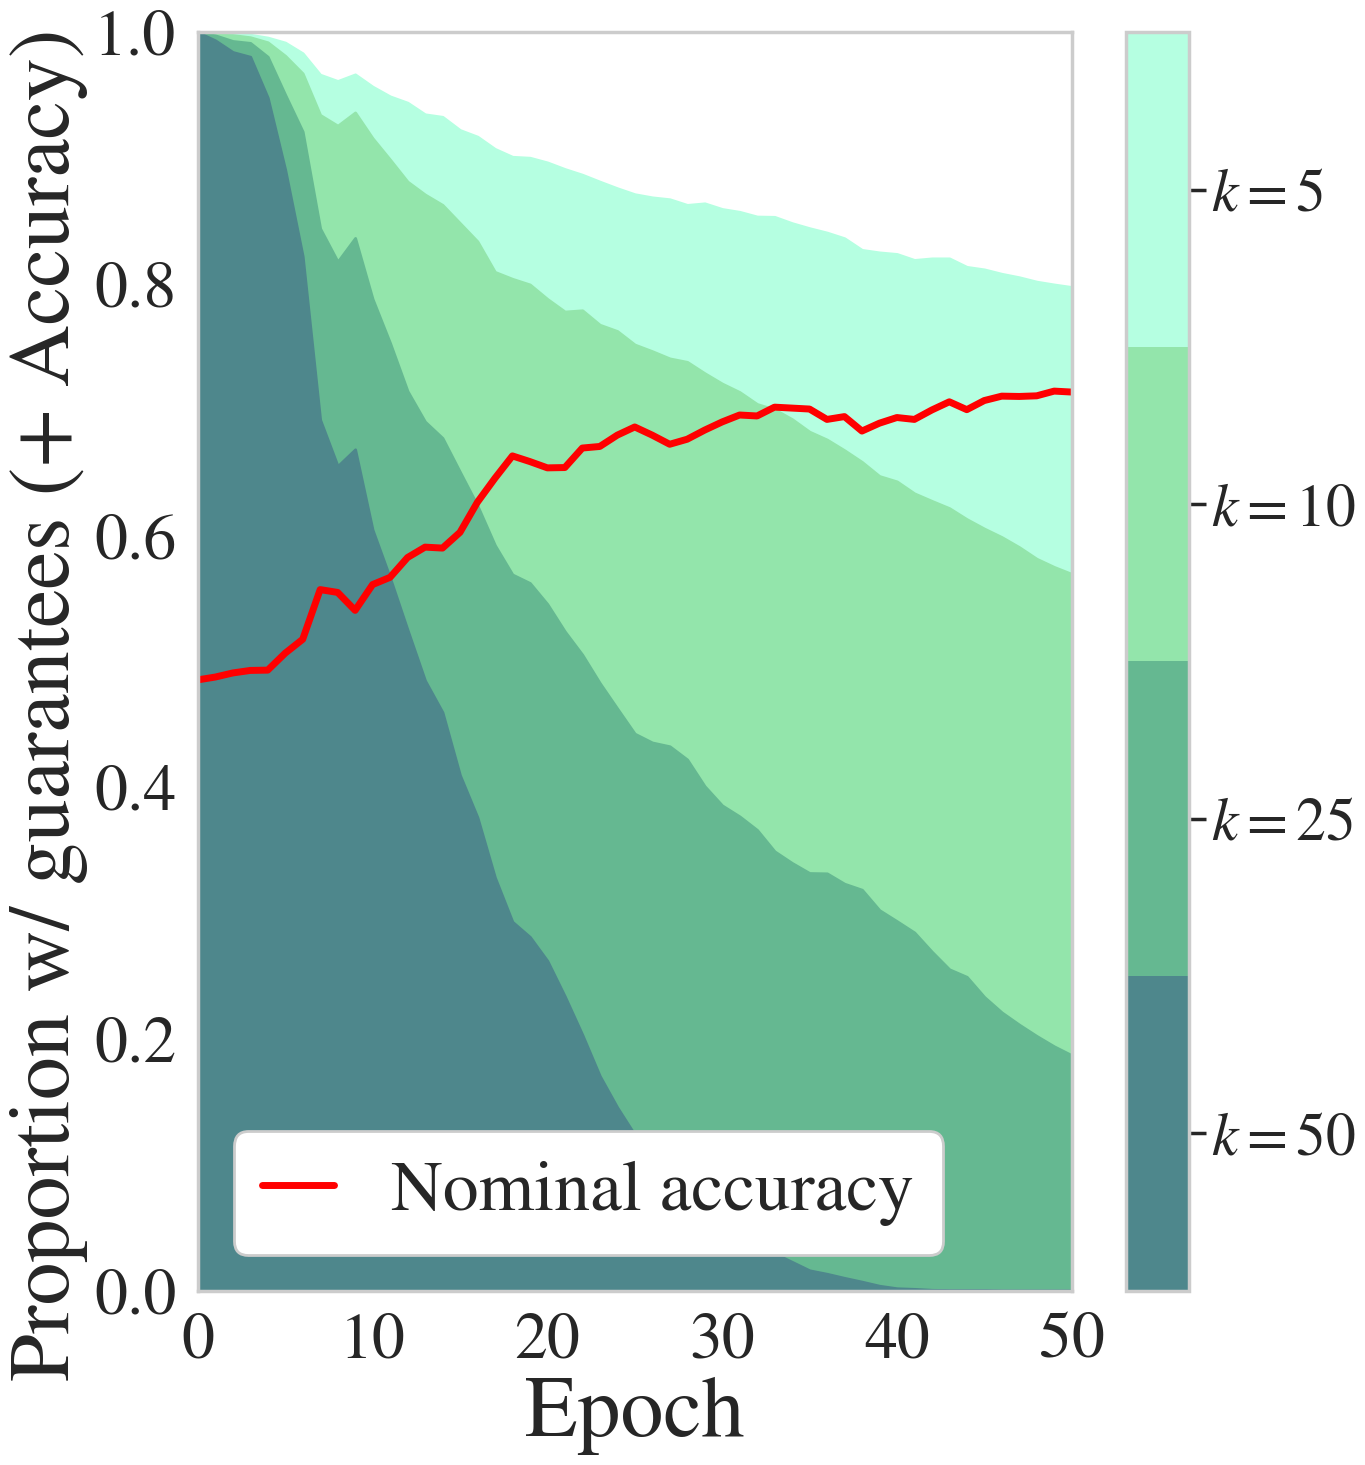

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(15, 16), layout="tight")

# plot privacy results
colors = iter(privacy_palette)
ax.fill_between(epochs, [1] * len(nom_acc_privacy), color="#ffffff")
for k, v in privacy_results.items():
    ax.fill_between(epochs, [x[1] for x in v], color=next(colors))

# axs[1].set_title("Rate of\nPrivacy-Safe Predictions", fontsize=fontsize, pad=50)
ax.set_xlim(0, len(nom_acc_privacy) - 1)
ax.set_ylim(0, 1)
ax.plot(epochs, nom_acc_privacy, color="red", label="Nominal accuracy", lw=5)
ax.set_xlabel("Epoch", fontsize=fontsize)
ax.set_ylabel("Proportion w/ guarantees (+ Accuracy)    ", fontsize=fontsize)
ax.legend(loc="lower left", fontsize="medium", framealpha=1.0, handlelength=1.0)
ax.set_xticks(range(0, len(nom_acc_privacy) + 1, 10))

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.colors.ListedColormap(privacy_palette[::-1])),
    ax=ax,
    orientation="vertical",
)
cbar.set_ticks([0.125, 0.375, 0.625, 0.875])
cbar.set_ticklabels([f"$k={k}$" for k in k_private][::-1], fontsize="small")

plt.savefig(".figures/gpt2_finetuning_privacy.pdf", bbox_inches="tight", dpi=300)


In [13]:
conf = copy.deepcopy(nominal_config)
conf.k_private = 1
conf.n_epochs = 76
conf.dp_sgd_sigma = 1.0
conf.learning_rate = 0.1


print("Epsilon: ", get_epsilon_delta(conf, train_loader, delta=10e-5))  # sigma=1.0, eps=25.5

/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 0, epsilon: 3.3321408742069005
Epoch 1, epsilon: 4.614168019107541
Epoch 2, epsilon: 5.582599560858556
Epoch 3, epsilon: 6.403659578845254
Epoch 4, epsilon: 7.134844526536092
Epoch 5, epsilon: 7.806607403657284
Epoch 6, epsilon: 8.432248267770925
Epoch 7, epsilon: 9.020307480948109
Epoch 8, epsilon: 9.580520205084232
Epoch 9, epsilon: 10.124144612205237
Epoch 10, epsilon: 10.63470499312889
Epoch 11, epsilon: 11.141727432260524
Epoch 12, epsilon: 11.618997781758633
Epoch 13, epsilon: 12.096268131256739
Epoch 14, epsilon: 12.553473753212652
Epoch 15, epsilon: 12.998796468399487
Epoch 16, epsilon: 13.44411918358632
Epoch 17, epsilon: 13.876799348830858
Epoch 18, epsilon: 14.29150486601926
Epoch 19, epsilon: 14.706210383207663
Epoch 20, epsilon: 15.120915900396065
Epoch 21, epsilon: 15.530687436823248
Epoch 22, epsilon: 15.916085909330535
Epoch 23, epsilon: 16.30148438183782
Epoch 24, epsilon: 16.686882854345107
Epoch 25, epsilon: 17.07228132685239
Epoch 26, epsilon: 17.4576797993596

In [14]:
torch.manual_seed(seed)
np.random.seed(seed)

conf = copy.deepcopy(nominal_config)
conf.k_private = 1
conf.n_epochs = 76
conf.dp_sgd_sigma = 1.0
conf.learning_rate = 0.1


training = []
def log(x, param_l, param_n, param_u):
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
    )
    training.append((x[1], percent_certified,))  # nom acc, percent certified

param_l, param_n, param_u = agt.privacy_certified_training(
    model, conf, train_loader, test_loader, transform=ct_utils.propagate_conv_layers, log_fn=log
)

09/25/2024 00:29:38:INFO:=================== Starting Privacy Certified Training ===================
09/25/2024 00:29:38:INFO:Starting epoch 1
09/25/2024 00:29:39:INFO:Training batch 1: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.0 
09/25/2024 00:29:40:INFO:Starting epoch 2
09/25/2024 00:29:40:INFO:Training batch 2: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.000441 
09/25/2024 00:29:41:INFO:Starting epoch 3
09/25/2024 00:29:42:INFO:Training batch 3: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.000685 
09/25/2024 00:29:43:INFO:Starting epoch 4
09/25/2024 00:29:43:INFO:Training batch 4: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.000892 
09/25/2024 00:29:44:INFO:Starting epoch 5
09/25/2024 00:29:44:INFO:Training batch 5: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.00107 
09/25/2024 00:29:46:INFO:Starting epoch 6
09/25/2024 00:29:46:INFO:Training batch 6: Network eval bounds=(0.51, 0.51, 0.51), W0 Bound=0.00126 
09/25/2024 00:29:47:INFO:Starting epoch 7


In [15]:
torch.manual_seed(seed)
np.random.seed(seed)

conf = copy.deepcopy(nominal_config)
conf.k_private = 100
conf.n_epochs = 76
conf.dp_sgd_sigma = 1.0
conf.learning_rate = 0.1


training = []
def log(x, param_l, param_n, param_u):
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
    )
    training.append((x[1], percent_certified,))  # nom acc, percent certified

param_l, param_n, param_u = agt.privacy_certified_training(
    model, conf, train_loader, test_loader, transform=ct_utils.propagate_conv_layers, log_fn=log
)

09/25/2024 00:31:33:INFO:=================== Starting Privacy Certified Training ===================
09/25/2024 00:31:33:INFO:Starting epoch 1
09/25/2024 00:31:34:INFO:Training batch 1: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.0 
09/25/2024 00:31:35:INFO:Starting epoch 2
09/25/2024 00:31:35:INFO:Training batch 2: Network eval bounds=(0.48, 0.49, 0.5 ), W0 Bound=0.037 
09/25/2024 00:31:36:INFO:Starting epoch 3
09/25/2024 00:31:37:INFO:Training batch 3: Network eval bounds=(0.48, 0.49, 0.53), W0 Bound=0.0582 
09/25/2024 00:31:38:INFO:Starting epoch 4
09/25/2024 00:31:38:INFO:Training batch 4: Network eval bounds=(0.48, 0.49, 0.55), W0 Bound=0.0768 
09/25/2024 00:31:39:INFO:Starting epoch 5
09/25/2024 00:31:40:INFO:Training batch 5: Network eval bounds=(0.45, 0.49, 0.65), W0 Bound=0.0932 
09/25/2024 00:31:41:INFO:Starting epoch 6
09/25/2024 00:31:41:INFO:Training batch 6: Network eval bounds=(0.43, 0.51, 0.74), W0 Bound=0.11 
09/25/2024 00:31:42:INFO:Starting epoch 7
09/25/2024 

In [16]:
torch.manual_seed(seed)
np.random.seed(seed)

conf = copy.deepcopy(nominal_config)
conf.k_private = 1000
conf.n_epochs = 76
conf.dp_sgd_sigma = 1.0
conf.learning_rate = 0.1


training = []
def log(x, param_l, param_n, param_u):
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(test_loader)), model, ct_utils.propagate_conv_layers
    )
    training.append((x[1], percent_certified,))  # nom acc, percent certified

param_l, param_n, param_u = agt.privacy_certified_training(
    model, conf, train_loader, test_loader, transform=ct_utils.propagate_conv_layers, log_fn=log
)

09/25/2024 00:34:49:INFO:=================== Starting Privacy Certified Training ===================
09/25/2024 00:34:49:INFO:Starting epoch 1
09/25/2024 00:34:50:INFO:Training batch 1: Network eval bounds=(0.49, 0.49, 0.49), W0 Bound=0.0 
09/25/2024 00:34:51:INFO:Starting epoch 2
09/25/2024 00:34:51:INFO:Training batch 2: Network eval bounds=(0   , 0.49, 1   ), W0 Bound=0.331 
09/25/2024 00:34:52:INFO:Starting epoch 3
09/25/2024 00:34:53:INFO:Training batch 3: Network eval bounds=(0   , 0.49, 1   ), W0 Bound=0.511 
09/25/2024 00:34:54:INFO:Starting epoch 4
09/25/2024 00:34:55:INFO:Training batch 4: Network eval bounds=(0   , 0.49, 1   ), W0 Bound=0.653 
09/25/2024 00:34:56:INFO:Starting epoch 5
09/25/2024 00:34:56:INFO:Training batch 5: Network eval bounds=(0   , 0.49, 1   ), W0 Bound=0.772 
09/25/2024 00:34:57:INFO:Starting epoch 6
09/25/2024 00:34:58:INFO:Training batch 6: Network eval bounds=(0   , 0.51, 1   ), W0 Bound=0.874 
09/25/2024 00:34:59:INFO:Starting epoch 7
09/25/2024 00

In [18]:
print(training[0])
print(training[25])
print(training[50])
print(training[75])

(0.4853786826133728, 1.0)
(0.6863284707069397, 0.9727568626403809)
(0.71407151222229, 0.9660085439682007)
(0.7403149604797363, 0.9587603211402893)
